In [1]:
from posebusters.posebusters import PoseBusters
from rdkit import Chem
import os
import pandas as pd
import re 
from typing import List

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [11]:
df_combined = pd.read_csv("plinder_set_0_annotated.csv")
df_combined['rmsd_≤_1å'] = df_combined['rmsd'] <=1 
df_combined['rmsd_≤_2å'] = df_combined['rmsd'] <=2
df_combined['rmsd_≤_5å'] = df_combined['rmsd'] <=5

# Create separate dataframes for each case - handle NaN values
df_covalent = df_combined[df_combined['ligand_is_covalent'].fillna(False)].reset_index(drop=True)
df_ionic = df_combined[df_combined['ligand_is_ion'].fillna(False)].reset_index(drop=True)
df_with_ion = df_combined[df_combined['has_ion'].fillna(False)].reset_index(drop=True)
df_cofactor = df_combined[df_combined['ligand_is_cofactor'].fillna(False)].reset_index(drop=True)

# Standard cases (none of the above)
mask = ~(
    df_combined['ligand_is_covalent'].fillna(False) |
    df_combined['ligand_is_ion'].fillna(False) |
    df_combined['has_ion'].fillna(False) |
    df_combined['ligand_is_cofactor'].fillna(False)
)
df_standard = df_combined[mask].reset_index(drop=True)

# Print shapes of all dataframes
print("Full dataset shape:", df_combined.shape)
print("Covalent ligands shape:", df_covalent.shape)
print("Ionic ligands shape:", df_ionic.shape)
print("Ligands with ions shape:", df_with_ion.shape)
print("Cofactor ligands shape:", df_cofactor.shape)
print("Standard ligands shape:", df_standard.shape)

Full dataset shape: (26726, 156)
Covalent ligands shape: (2972, 156)
Ionic ligands shape: (0, 156)
Ligands with ions shape: (7345, 156)
Cofactor ligands shape: (3058, 156)
Standard ligands shape: (14961, 156)


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_84683/824796994.py:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv("plinder_set_0_annotated.csv")


In [13]:
print("Standard: Total number of unique systems:", df_combined['protein'].nunique())
print("Covalent: Total number of unique systems:", df_covalent['protein'].nunique())
print("Ionic: Total number of unique systems:", df_ionic['protein'].nunique())
print("With ion: Total number of unique systems:", df_with_ion['protein'].nunique())
print("Cofactor: Total number of unique systems:", df_cofactor['protein'].nunique())

Standard: Total number of unique systems: 1036
Covalent: Total number of unique systems: 113
Ionic: Total number of unique systems: 0
With ion: Total number of unique systems: 296
Cofactor: Total number of unique systems: 143


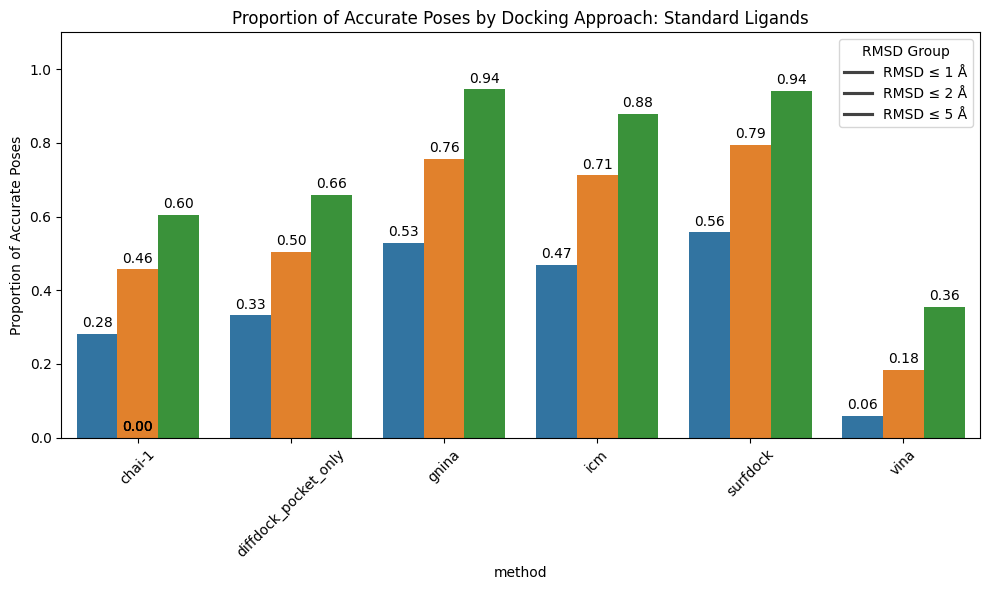

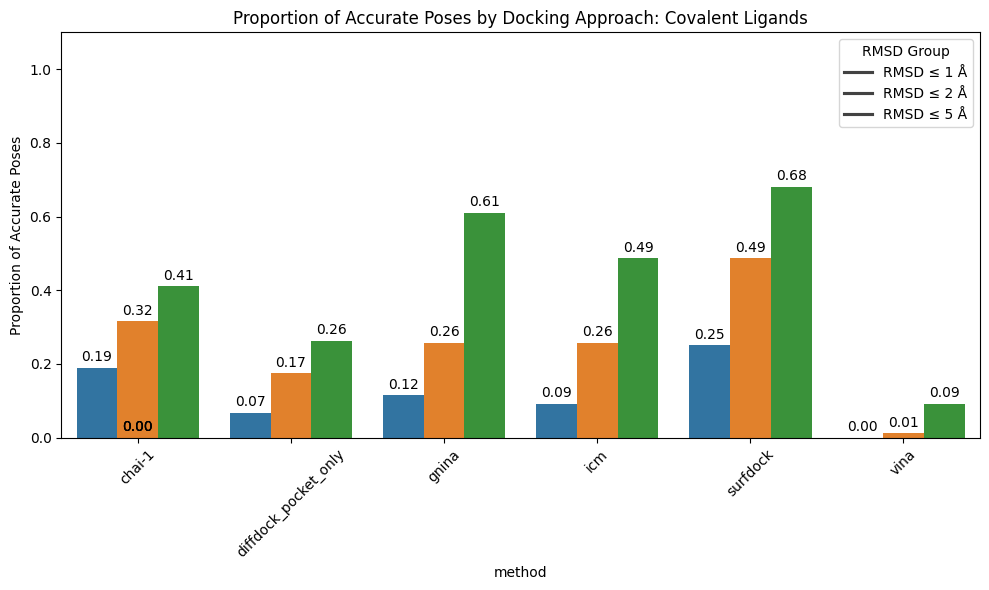

Skipping plot for Ionic Ligands - DataFrame is empty


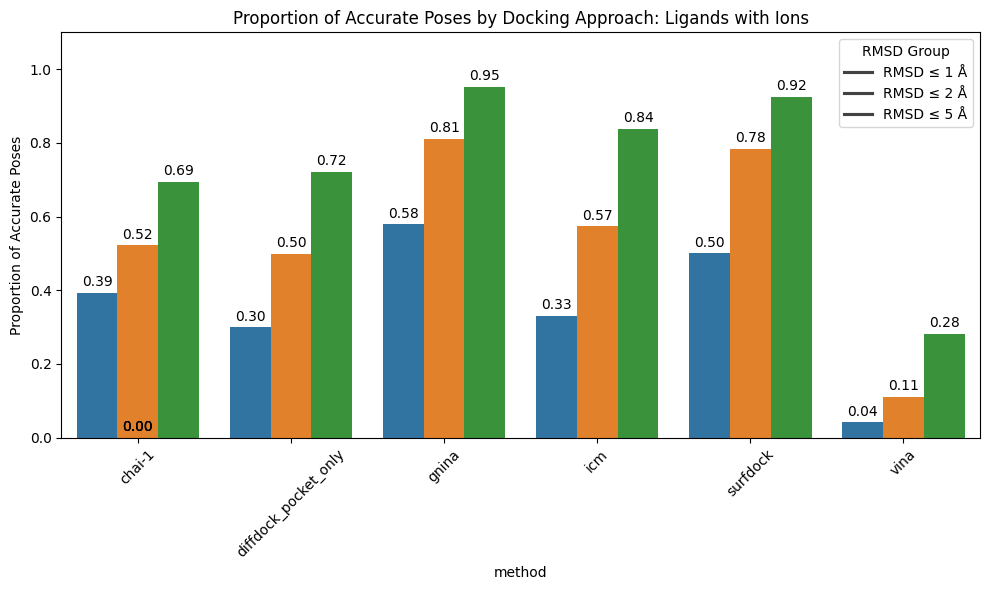

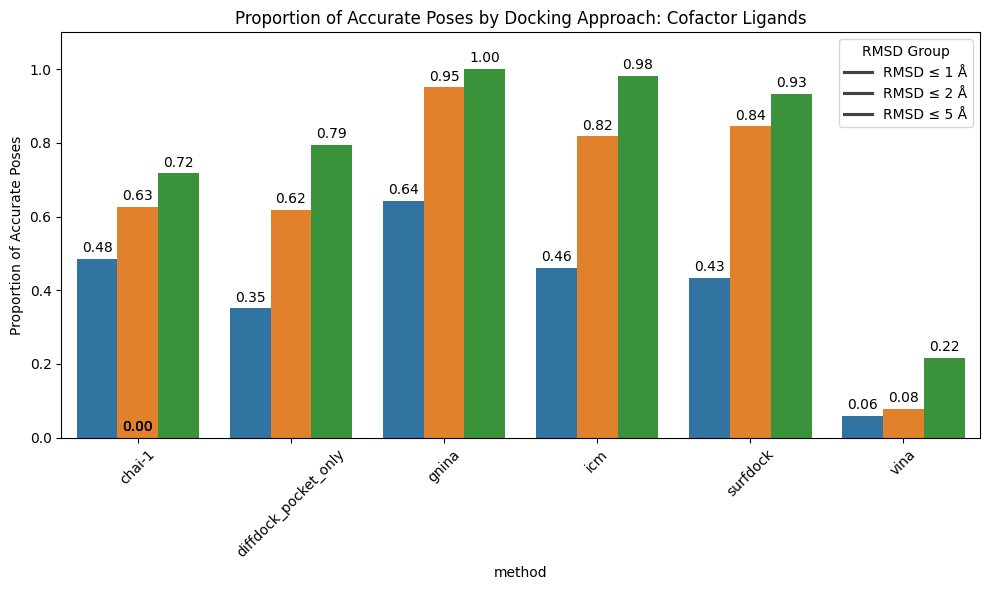

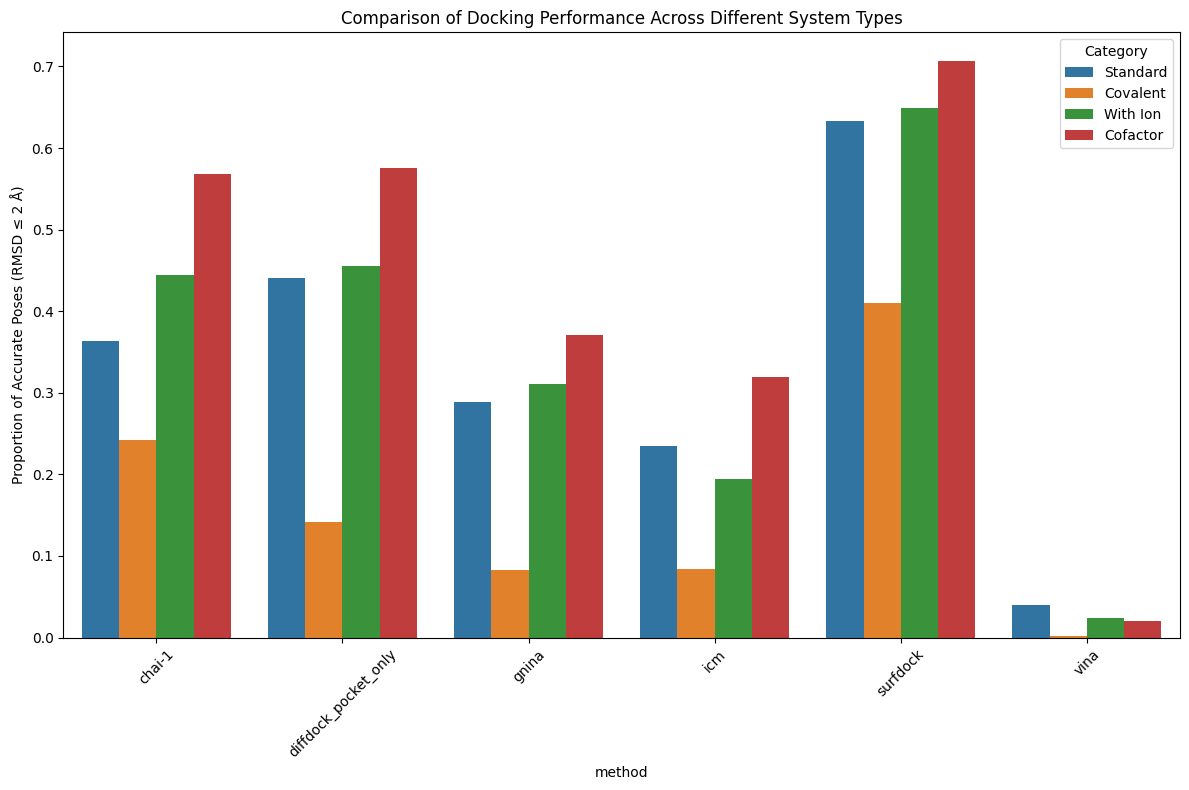

In [12]:

def plot_rmsd_success_by_category(df, title, figsize=(10, 6)):
    if df.empty:
        print(f"Skipping plot for {title} - DataFrame is empty")
        return
    
    # Create success columns for each RMSD threshold
    df['success_1å'] = df['rmsd_≤_1å'] if 'rmsd_≤_1å' in df.columns else False
    df['success_2å'] = df['rmsd_≤_2å']
    df['success_5å'] = df['rmsd_≤_5å'] if 'rmsd_≤_5å' in df.columns else df['rmsd_≤_2å']  # Fallback if 5Å not available
    
    # Group by protein and method, and check if any conformer satisfies each threshold
    success_agg = df.groupby(['protein', 'method']).agg({
        'success_1å': 'max',
        'success_2å': 'max',
        'success_5å': 'max'
    }).reset_index()
    
    # Melt the aggregated DataFrame for plotting
    melted_success = success_agg.melt(
        id_vars=['protein', 'method'],
        value_vars=['success_1å', 'success_2å', 'success_5å'],
        var_name='RMSD_Group',
        value_name='Is_Accurate'
    )
    
    # Calculate the proportion of accurate poses
    prop_success = melted_success.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()
    
    # Create plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=prop_success,
        x='method',
        y='Is_Accurate',
        hue='RMSD_Group'
    )
    
    # Annotate each bar with its height (proportion)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f"{height:.2f}",
            ha='center',
            va='bottom'
        )
    
    plt.ylabel('Proportion of Accurate Poses')
    plt.title(f'Proportion of Accurate Poses by Docking Approach: {title}')
    plt.legend(
        title='RMSD Group',
        labels=['RMSD ≤ 1 Å', 'RMSD ≤ 2 Å', 'RMSD ≤ 5 Å']
    )
    plt.xticks(rotation=45)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

# Plot for each category
plot_rmsd_success_by_category(df_standard, "Standard Ligands")
plot_rmsd_success_by_category(df_covalent, "Covalent Ligands") 
plot_rmsd_success_by_category(df_ionic, "Ionic Ligands")
plot_rmsd_success_by_category(df_with_ion, "Ligands with Ions")
plot_rmsd_success_by_category(df_cofactor, "Cofactor Ligands")

# Create a combined comparison plot
plt.figure(figsize=(12, 8))

# Create a dataframe to hold success rates for each category
categories = {
    'Standard': df_standard,
    'Covalent': df_covalent,
    'With Ion': df_with_ion,
    'Cofactor': df_cofactor
}

comparison_data = []

for category_name, df in categories.items():
    if not df.empty:
        df['success_2å'] = df['rmsd_≤_2å']
        success_rate = df.groupby('method')['success_2å'].mean().reset_index()
        success_rate['Category'] = category_name
        comparison_data.append(success_rate)

comparison_df = pd.concat(comparison_data)

# Plot comparison
sns.barplot(data=comparison_df, x='method', y='success_2å', hue='Category')
plt.ylabel('Proportion of Accurate Poses (RMSD ≤ 2 Å)')
plt.title('Comparison of Docking Performance Across Different System Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

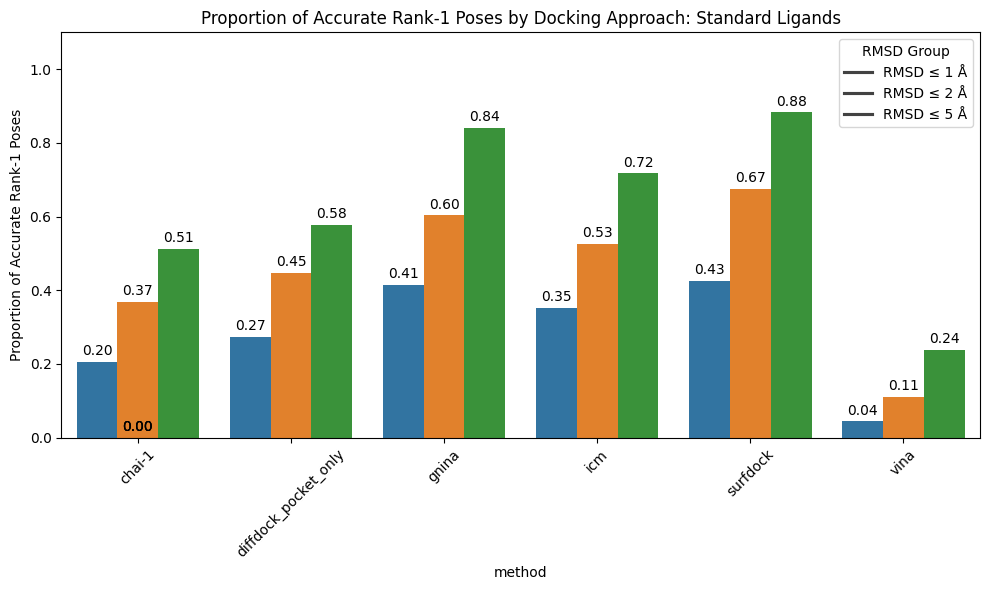

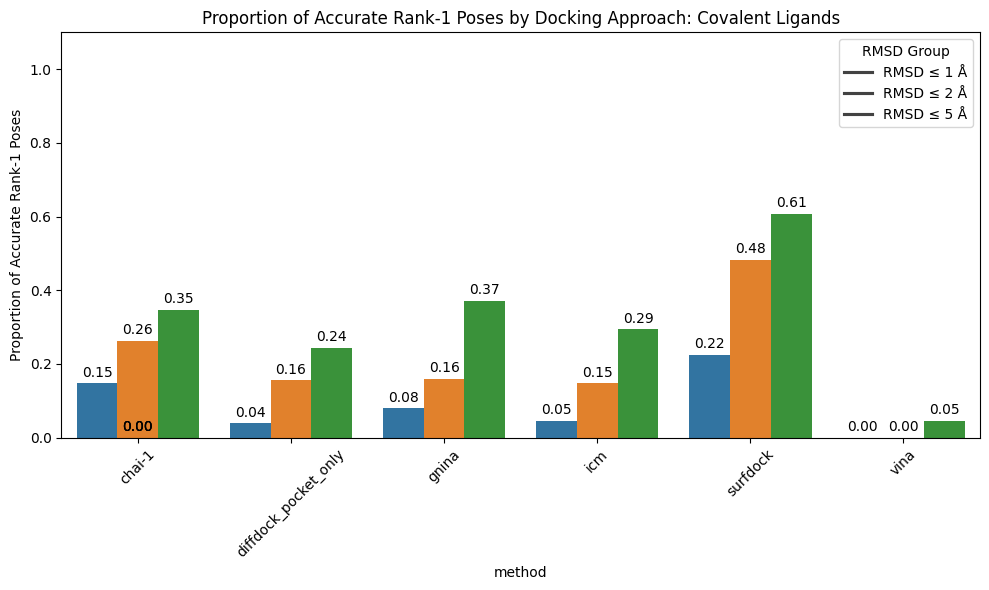

Skipping plot for Ionic Ligands - DataFrame is empty


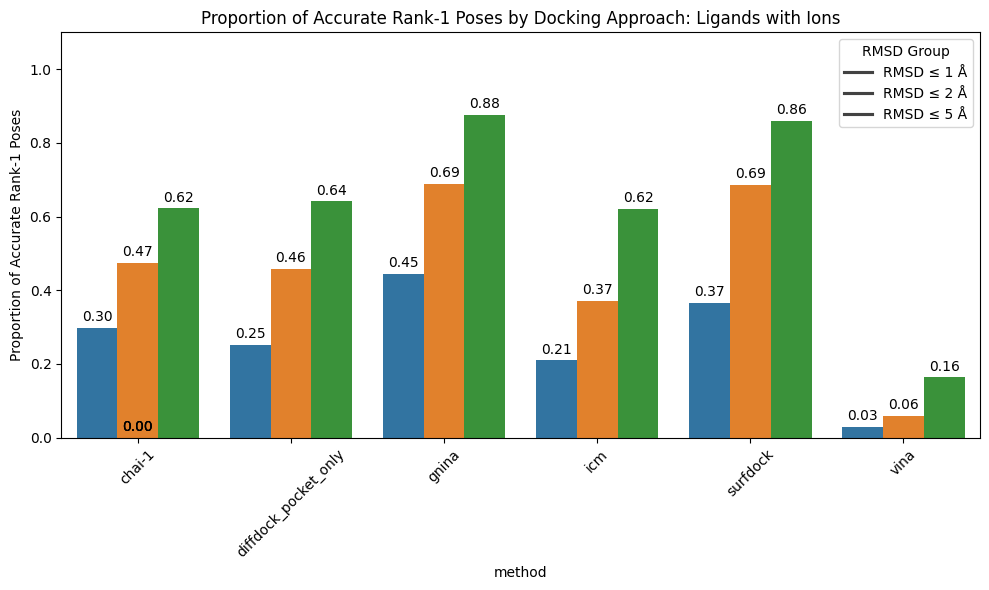

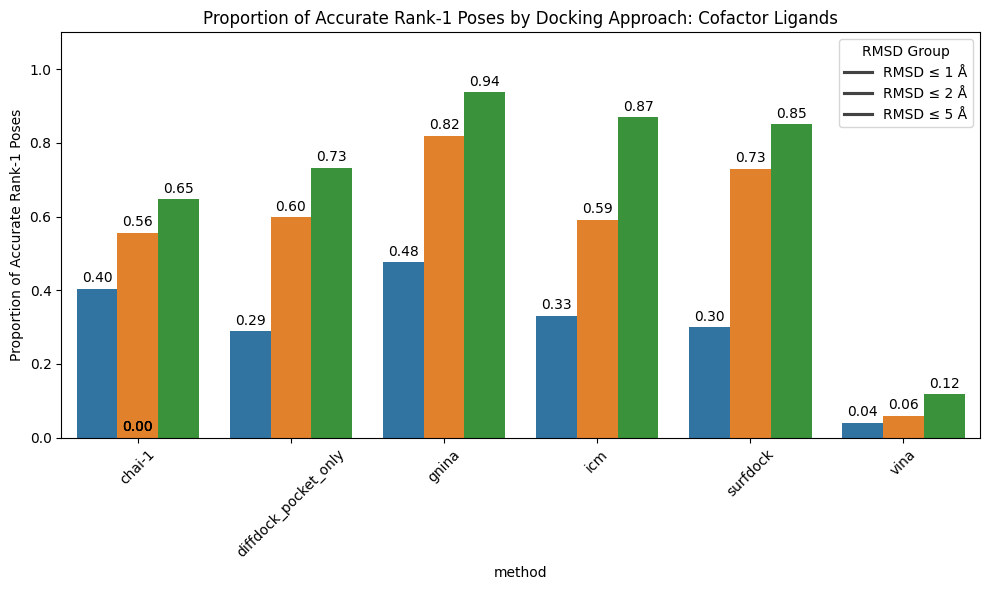

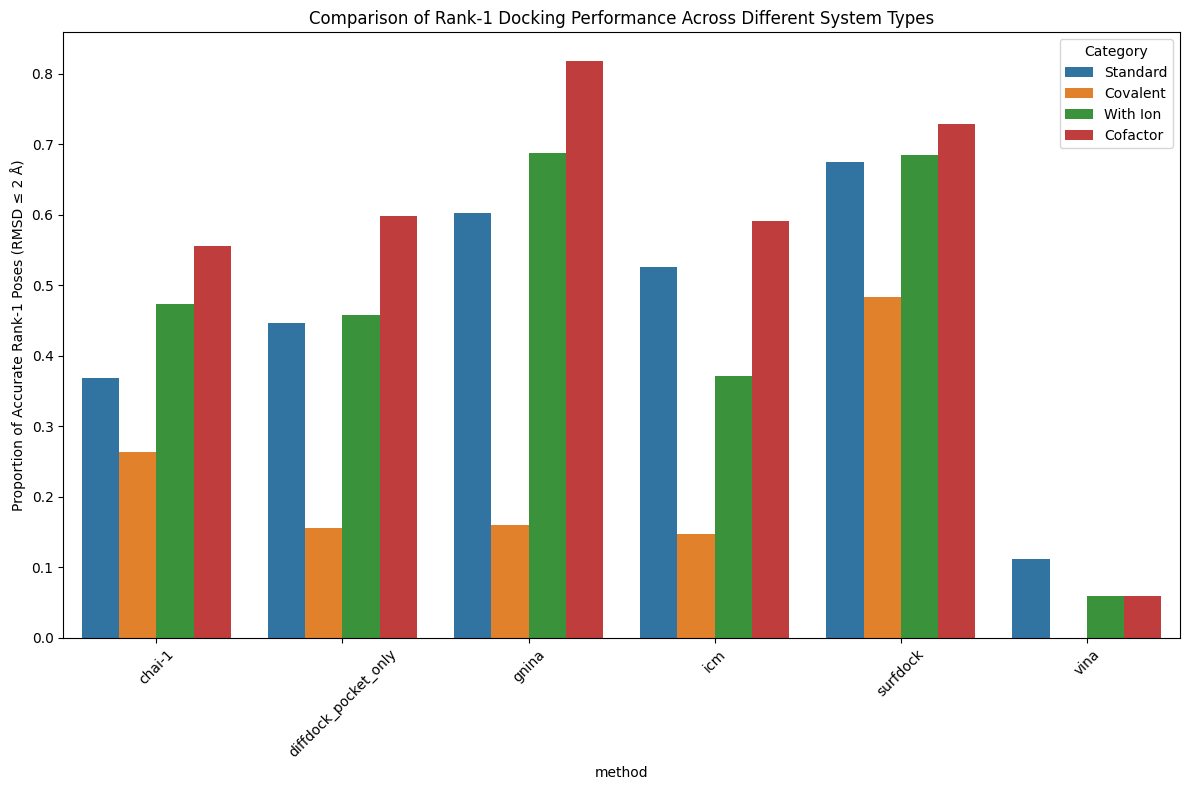

In [22]:
def plot_rank_1_rmsd_success_by_category(df, title, figsize=(10, 6)):
    if df.empty:
        print(f"Skipping plot for {title} - DataFrame is empty")
        return
    
    # Filter to only rank 1 results (lowest score)
    rank1_df = df[df['rank'] == 1].copy()
    
    if rank1_df.empty:
        print(f"Skipping plot for {title} - No rank 1 results found")
        return
    
    # Create success columns for each RMSD threshold
    rank1_df['success_1å'] = rank1_df['rmsd_≤_1å'] if 'rmsd_≤_1å' in rank1_df.columns else False
    rank1_df['success_2å'] = rank1_df['rmsd_≤_2å']
    rank1_df['success_5å'] = rank1_df['rmsd_≤_5å'] if 'rmsd_≤_5å' in rank1_df.columns else rank1_df['rmsd_≤_2å']
    
    # Since we're already looking at rank 1, we don't need to group by protein and take max
    # Just melt the DataFrame for plotting
    melted_success = rank1_df.melt(
        id_vars=['protein', 'method'],
        value_vars=['success_1å', 'success_2å', 'success_5å'],
        var_name='RMSD_Group',
        value_name='Is_Accurate'
    )
    
    # Calculate the proportion of accurate poses
    prop_success = melted_success.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()
    
    # Create plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=prop_success,
        x='method',
        y='Is_Accurate',
        hue='RMSD_Group'
    )
    
    # Annotate each bar with its height (proportion)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f"{height:.2f}",
            ha='center',
            va='bottom'
        )
    
    plt.ylabel('Proportion of Accurate Rank-1 Poses')
    plt.title(f'Proportion of Accurate Rank-1 Poses by Docking Approach: {title}')
    plt.legend(
        title='RMSD Group',
        labels=['RMSD ≤ 1 Å', 'RMSD ≤ 2 Å', 'RMSD ≤ 5 Å']
    )
    plt.xticks(rotation=45)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

# Plot for each category
plot_rank_1_rmsd_success_by_category(df_standard, "Standard Ligands")
plot_rank_1_rmsd_success_by_category(df_covalent, "Covalent Ligands") 
plot_rank_1_rmsd_success_by_category(df_ionic, "Ionic Ligands")
plot_rank_1_rmsd_success_by_category(df_with_ion, "Ligands with Ions")
plot_rank_1_rmsd_success_by_category(df_cofactor, "Cofactor Ligands")

# Create a combined comparison plot for rank-1 results
plt.figure(figsize=(12, 8))

categories = {
    'Standard': df_standard,
    'Covalent': df_covalent,
    'With Ion': df_with_ion,
    'Cofactor': df_cofactor
}

comparison_data = []

for category_name, df in categories.items():
    if not df.empty:
        # Filter to rank 1 results only
        rank1_df = df[df['rank'] == 1].copy()
        if not rank1_df.empty:
            rank1_df['success_2å'] = rank1_df['rmsd_≤_2å']
            success_rate = rank1_df.groupby('method')['success_2å'].mean().reset_index()
            success_rate['Category'] = category_name
            comparison_data.append(success_rate)

if comparison_data:
    comparison_df = pd.concat(comparison_data)
    
    # Plot comparison
    sns.barplot(data=comparison_df, x='method', y='success_2å', hue='Category')
    plt.ylabel('Proportion of Accurate Rank-1 Poses (RMSD ≤ 2 Å)')
    plt.title('Comparison of Rank-1 Docking Performance Across Different System Types')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No rank-1 data available for comparison plot")